# Improved Wasserstein GAN in Pytorch

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms, utils
%matplotlib inline

First, we, set up batch size, image size, and size of noise vector:

In [2]:
bs,sz,nz = 8,128,128
LAMBDA = 10
PATH_G = 'iwgancv5_g'
PATH_D = 'iwgancv5_d'

In [3]:
PATH = '/home/m20163692/data/lsun'
data = datasets.LSUN(db_path=PATH, classes=['church_outdoor_train'],
    transform=transforms.Compose([
        transforms.Scale(sz),
        transforms.CenterCrop(sz),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

Even parallel processing is handling automatically by torch-vision.

In [4]:
dataloader = torch.utils.data.DataLoader(data, bs, True, num_workers=8)
n = len(dataloader); n

7890

In [5]:
next(iter(dataloader))[0].size()

torch.Size([16, 3, 128, 128])

Our activation function will be `tanh`, so we need to do some processing to view the generated images.

In [6]:
def show(img, fs=(8,8)):
    plt.figure(figsize = fs)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')
    plt.show()

## Create model

In [7]:
import importlib
import torch.nn as nn
from torch import optim
from torch.autograd import Variable, grad
import iwgan_3conv; importlib.reload(iwgan_3conv)
from iwgan_3conv import D, G, weights_init

Pytorch uses `module.apply()` for picking an initializer.

In [8]:
netG = G(nz).cuda()
netG.apply(weights_init);

netD = D(nz).cuda()
netD.apply(weights_init);

Just some shortcuts to create tensors and variables.

In [9]:
from torch import FloatTensor as FT

def Var(*params):
    return Variable(FT(*params).cuda())

def create_noise(b, volatile=False): 
    return Variable(FT(b, nz).cuda().normal_(0, 1), volatile=volatile)

In [10]:
# Input placeholder
input = Var(bs, 3, sz, nz)
# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)
# The numbers 1 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

Adam parameters from paper

In [11]:
# TODO ADAM
optimizerD = optim.Adam(netD.parameters(), lr = 1e-4, betas=(0.5, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr = 1e-4, betas=(0.5, 0.9))

One forward step and one backward step for D

In [15]:
# data_iter = iter(dataloader)
# real = Variable(next(data_iter)[0].cuda())
# real.size()

torch.Size([32, 3, 128, 128])

In [23]:
# fake = netG(create_noise(real.size()[0]))
# fake.size()

torch.Size([64, 3, 128, 128])

In [24]:
# alpha = torch.rand(bs,1,1,1).cuda()
# alpha = alpha.expand_as(real)
# alpha.size()

torch.Size([64, 3, 128, 128])

In [25]:
# interpolates = (alpha * real.data) + ((1 - alpha) * fake.data)
# interpolates.size()

torch.Size([64, 3, 128, 128])

In [26]:
# interpolates = torch.autograd.Variable(interpolates, requires_grad=True)
# D_interpolates = netD(interpolates)
# D_interpolates.size()

torch.Size([64, 1])

In [32]:
# gradients = grad(D_interpolates, interpolates, create_graph=True)[0]
# gradients.size()

In [97]:
# gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
# gradient_penalty.size()

torch.Size([1])

In [ ]:
# D_loss = D_fake - D_real + LAMBDA * gradient_penalty
# D_loss.backward()
# optimizerD.step()

In [12]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

def calc_gradient_penalty(netD, real, fake):
    alpha = torch.rand(bs,1,1,1).cuda()
    alpha = alpha.expand(real.size())
    interpolates = (alpha * real.data) + ((1 - alpha) * fake.data)
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)
    disc_interpolates = netD(interpolates)
    gradients = grad(disc_interpolates, interpolates, create_graph=True)[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA

    return gradient_penalty

def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

def train(niter, first=True):
    netG.train()
    gen_iterations = 0
    save_flag = 1
    for epoch in range(niter):
        t0 = time()
        data_iter = iter(dataloader)
        i = 0
        while i < n:
            make_trainable(netD, True)
            #d_iters = (50 if first and (gen_iterations < 5) or gen_iterations % 500 == 0 
            #           else 5)
            d_iters = 5
            j = 0
            while j < d_iters and i < n:
                j += 1; i += 1
                print(f'{i:04}/{n:04} - G_iterations: {gen_iterations:04}', end='\r')
                real = Variable(next(data_iter)[0].cuda())
                # real loss
                netD.zero_grad()
                errD_real = step_D(real, mone)
                # fake loss
                fake = netG(create_noise(real.size()[0]))
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, one)
                # Gradient penalty (improved wgan paper):
                gradient_penalty = calc_gradient_penalty(netD, real, fake)
                gradient_penalty.backward()
                errD = errD_fake - errD_real + gradient_penalty
                optimizerD.step()
                
            make_trainable(netD, False)
            netG.zero_grad()
            errG = -step_D(netG(create_noise(bs)), mone)
            optimizerG.step()
            gen_iterations += 1
            if save_flag == -1:
                p_g = PATH_G + '_temp.pkl'
                p_d = PATH_D + '_temp.pkl'
            else:
                p_g = PATH_G + '.pkl'
                p_d = PATH_D + '.pkl'
            
            torch.save(netG.state_dict(), p_g)
            torch.save(netD.state_dict(), p_d)
            save_flag *= -1
            
            with open('logs/log.txt', 'a') as f:
                f.writelines('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f (%.2fs)\n' %
                             (epoch, niter, gen_iterations, n, errD.data[0], errG.data[0],
                              errD_real.data[0], errD_fake.data[0], time() - t0))
            
        print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f (%.2fs)' % (
            epoch, niter, gen_iterations, n,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0], time() - t0))

In [13]:
%%time
train(50000, True) # First run
# train(10000, False)

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1502009910772/work/torch/lib/THC/generic/THCStorage.cu:66

In [16]:
p_g = PATH_G + '.pkl'
p_d = PATH_D + '.pkl'
torch.save(netG.state_dict(), p_g)
torch.save(netD.state_dict(), p_d)

## View

In [17]:
# LOAD
netG.load_state_dict(torch.load(PATH_G + '.pkl'))
netD.load_state_dict(torch.load(PATH_D + '.pkl'))

In [19]:
netG

DCGAN_G (
  (main): Sequential (
    (initial_1-1024.UpSample): Upsample(scale_factor=2, mode=nearest)
    (initial_1-128.1024.conv): Conv2d(128, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (initial_1-1024.batchnorm): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
    (initial_1-1024.relu): ReLU (inplace)
    (initial_2-1024.UpSample): Upsample(scale_factor=2, mode=nearest)
    (initial_2-1024.1024.conv): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (initial_2-1024.batchnorm): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
    (initial_2-1024.relu): ReLU (inplace)
    (pyramid-512.UpSample): Upsample(scale_factor=2, mode=nearest)
    (pyramid-1024.512.conv): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pyramid-512.batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-512.relu): ReLU (inplace)
    (pyramid-256.UpSample): Upsample(scal

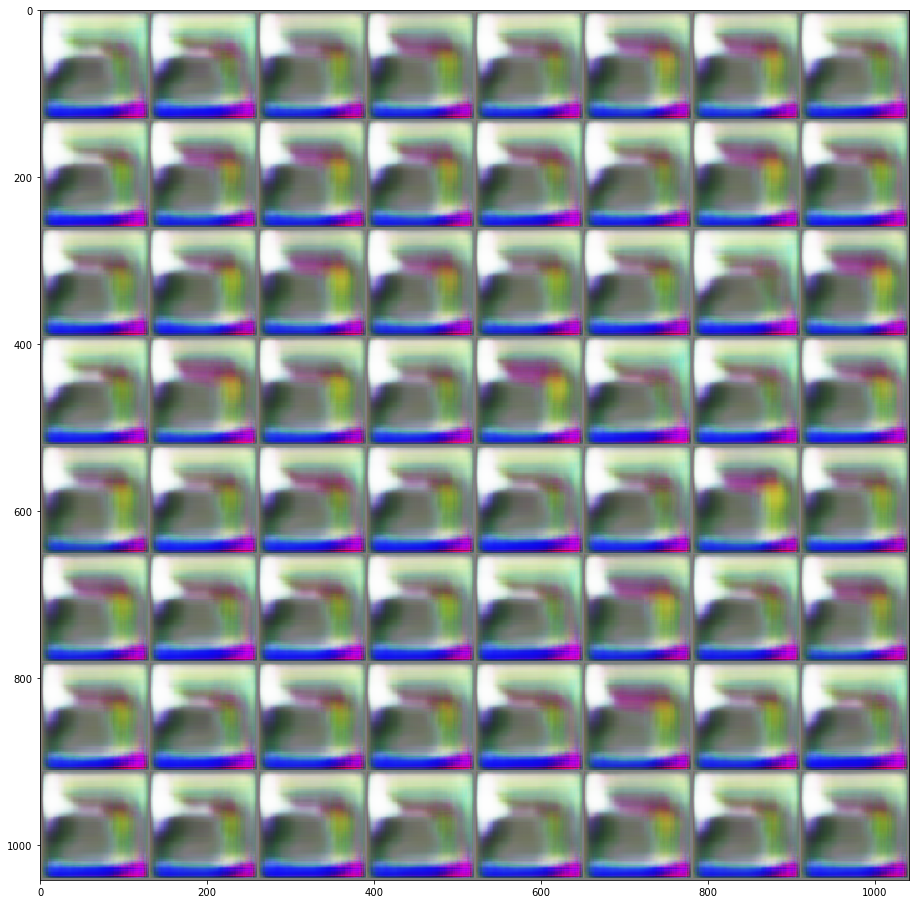

In [18]:
# model mode eval
netG.eval()
fixed_noise = create_noise(64)
fake = netG(fixed_noise).data.cpu()
# show(random.choice(fake))
show(utils.make_grid(fake), (16,16))

## Check interpolation

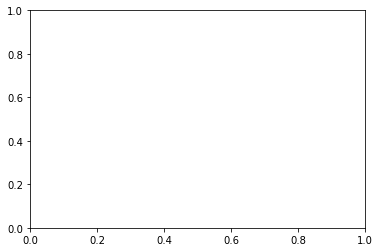

In [20]:
from IPython.display import HTML
from matplotlib import animation, rc

fig, ax = plt.subplots()

def animate(i):
    ax.imshow(np.transpose((interpolation[i]/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')

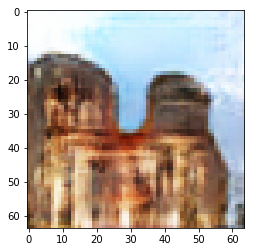

In [23]:
# get random image
i = 4
# noise_base = create_noise(1)
noise_base = fixed_noise[i].view(1,*fixed_noise[i].size())
show(netG(noise_base).data.cpu()[0], (4,4))

In [31]:
n_imgs = 100
# noise = create_noise(1)
noise = noise_base.repeat(n_imgs,1,1,1)

# pick dimension
r_dim = random.randint(0, noise.size()[1] - 1)
print(f'choosen dim = {r_dim}')
noise[:,r_dim] = torch.linspace(-3, 3, n_imgs)

# get & show imgs
interpolation = netG(noise).data.cpu()

choosen dim = 14


In [33]:
# show(utils.make_grid(interpolation, nrow=int(np.sqrt(n_imgs))), (16,16))

In [34]:
anim = animation.FuncAnimation(fig, animate, frames=n_imgs, interval=100)
HTML(anim.to_html5_video())

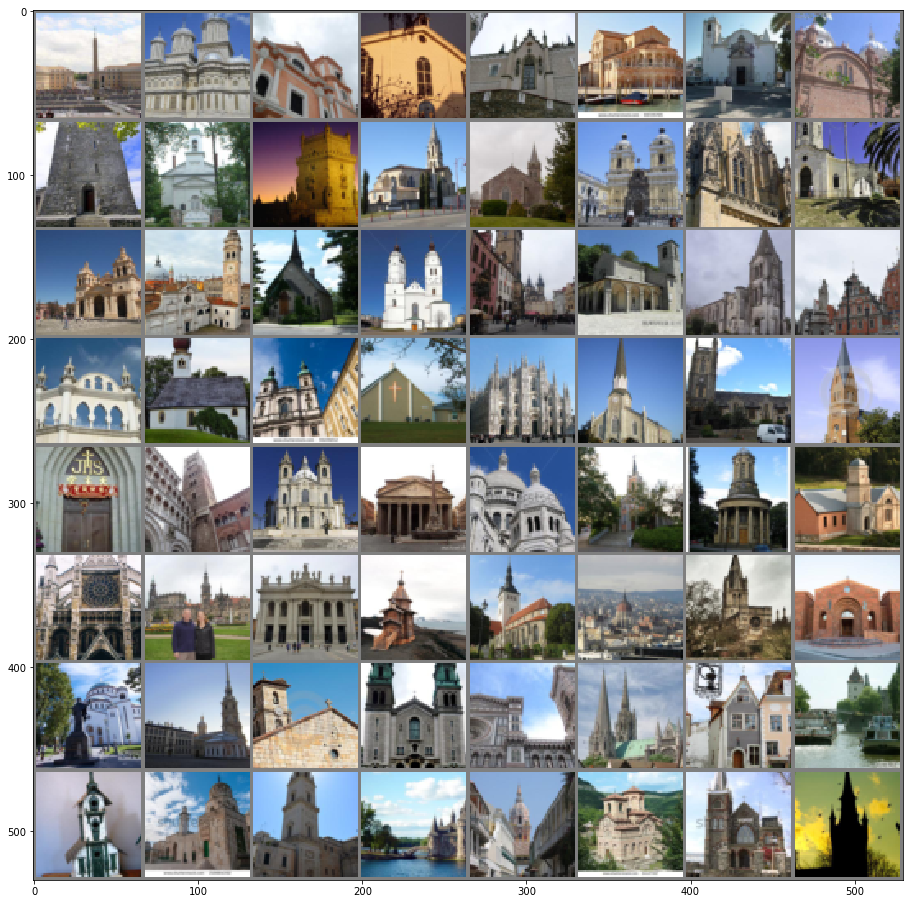

In [27]:
show(utils.make_grid(iter(dataloader).next()[0][:64]), (16,16))